# t3p2.ipynb

A simplifed version of the architecture in `test3p2.ipynb`.

### Using a simple feedback control architecture with the pendulum
Similar to the une used in t2p3.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
#np.random.seed(123456)
np.random.seed()
# Create the neuronal populations
C_type = "am2D" # unit type for the C population
des_angs = 0.1 + 0.8*np.random.random(1000) # list of "predicted" angles
pres_interv = 20. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))


#-------------------------------------------------------------------------
# network parameters
#-------------------------------------------------------------------------

net_params = {'min_delay' : 0.0025,
              'min_buff_size' : 8 }

#-------------------------------------------------------------------------
# unit parameters
#-------------------------------------------------------------------------
if C_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    C_unit_type = unit_types.am_pm_oscillator
elif C_type == "am2D":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_oscillator2D
elif C_type == "am_pulse":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_pulse
elif C_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    C_unit_type = unit_types.am_oscillator 
C_params = {'type' : C_unit_type, #unit_types.am_pm_oscillator,
            'integ_meth' : 'odeint',
            'tau_u' : 0.5 * randz2(), # 0.2*randz2()
            'tau_c' : 0.1 * randz2(), # 0.1
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : True,
            'omega' : 1.*np.pi,
            'F' : 'zero', #'input_sum',
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : 10.,
            'custom_inp_del' : 150,
            'delay' : 0.2,
            'A' : .2,
            'mu' : 0.,
            'sigma' : 0. }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
SP_params = {'type' : unit_types.source,
             'init_val' : des_angs[0],
             'function' : lambda t: des_angs[int(round(t/pres_interv))] }
SPF_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.5 * randz2(),
              'slope' : 4. * randz2(),
              'delay' : 0.2,
              'init_val' : 0.3 * randz2(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz2(),
              'des_out_w_abs_sum' : .8 }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#-------------------------------------------------------------------------
# plant parameters
#-------------------------------------------------------------------------
P_params = {'type' : plant_models.bouncy_pendulum,
            'length' : 0.5,
            'mass' : 1., #1.
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 0.,
            'inp_gain' : 2.,
            'mu' : .3, #0.22,
            'bound_angle' : True,
            'pi_visco' : 0.05,
            'tau' : 0.05 } # a made-up time constant for the plant 
                          # see create_freqs_steps below

#-------------------------------------------------------------------------
# Connection dictionaries
#-------------------------------------------------------------------------
# lateral connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
C__C_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -.5 }
# spinal units to plant
C0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
C0__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
C1__P_conn = C0__P_conn
C1__P_syn = {'type': synapse_types.static,
             'init_w' : -1. }
# plant to sensory
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# SF/SP to SPF
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SPF to C
SPF__C_conn = {'rule': 'all_to_all',
               'delay': 0.02 }
SPF__C_syn  = {'type' : synapse_types.rga_21,
               'lrate': 500., #50
               'inp_ports': 0,
               'init_w' : {'distribution':'uniform', 'low':0.2, 'high':.5} }

#-------------------------------------------------------------------------
# CREATING UNITS
#-------------------------------------------------------------------------
net = network(net_params)
SF = net.create(1, SF_params)
SP = net.create(1, SP_params)
SPF = net.create(2, SPF_params)
P = net.create(1, P_params)
# creating C with heterogeneous frequencies
def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        Args:
            n : number of units
            w : base angular frequency (rad/s)
            r : amplitude of noise
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w + r*(np.random.random(n) - 0.5)
    p_del = np.arctan(P_params['tau']*ws)/ws
    sf_del = np.arctan(SF_params['tau']*ws)/ws
    spf_del = np.arctan(SPF_params['tau']*ws)/ws
    c_del1 = np.arctan(C_params['tau_c']*ws)/ws
    c_del2 = np.arctan(C_params['tau_u']*ws)/ws
    d1 = p_del + sf_del + spf_del + 3.*0.02
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)
omegas, del_steps = create_freqs_steps(2, np.array([C_params['omega'] + 0.6*C_params['omega']]), par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(2, C_params)

#-------------------------------------------------------------------------
# CONNECTING
#-------------------------------------------------------------------------
net.connect([C[0]], [C[1]], C__C_conn, C__C_syn)
net.connect([C[1]], [C[0]], C__C_conn, C__C_syn)
net.set_plant_inputs([C[0]], P, C0__P_conn, C0__P_syn)
net.set_plant_inputs([C[1]], P, C1__P_conn, C1__P_syn)
net.connect(SP, SPF[0:-1], SPi__SPF_conn, SPi__SPF_syn) # index 0
net.connect(SF, SPF[0:-1], SFe__SPF_conn, SFe__SPF_syn)
net.connect(SP, SPF[1:], SPe__SPF_conn, SPe__SPF_syn) # index 1
net.connect(SF, SPF[1:], SFi__SPF_conn, SFi__SPF_syn)
net.connect(SPF, C, SPF__C_conn, SPF__C_syn)
net.set_plant_outputs(P, SF, P__SF_conn, P__SF_syn)

#-------------------------------------------------------------------------
# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# tracking units
SPF_C0_track = net.create(2, track_params) # to track weights from M to C0
xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of C0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
spj_track = net.create(1, track_params) # input derivative for SPF0--C0
dc_track = net.create(2, track_params) # DC component of C units

# This is dependent on the order in which net.connect is called above;
SPF__C_syns = [syn for syn in net.syns[C[0]] if syn.port == SPF__C_syn['inp_ports']]
net.units[SPF_C0_track[0]].set_function(lambda t: SPF__C_syns[0].w) # SPF0--C0
net.units[SPF_C0_track[1]].set_function(lambda t: SPF__C_syns[1].w) # SPF1--C0

# SETTING TRACKING OF PLASTICITY FACTORS FOR M0-->C0
net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[C[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
                                    net.units[C[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
ds = net.syns[C[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[SPF[0]].get_lpf_fast(ds) - 
                                     net.units[SPF[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF C STATE VARIABLES
net.units[dc_track[0]].set_function(lambda t: net.units[C[0]].buffer[1, -1])
net.units[dc_track[1]].set_function(lambda t: net.units[C[1]].buffer[1, -1])


In [17]:
C_params['omega']

[4.9860348949299045, 4.977346716762998]

In [18]:
for syn in net.syns[C[0]]:
    print(syn.w)
for syn in net.syns[C[1]]:
    print(syn.w)

-2.0
0.47344722030917236
0.21300300402594388
-2.0
0.4133270315399025
0.39634913880288414


In [14]:
net.units[C[0]].l1_norm_factor_mp

[1.110851025875397, 0.5]

In [3]:
net.syns[C[0]][1].w = .1
net.syns[C[0]][2].w = 1.
net.syns[C[1]][1].w = 1.
net.syns[C[1]][2].w = .1

In [3]:
start_time = time.time()
times, data, plant_data  = net.flat_run(100.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 36.57630920410156 seconds


In [30]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = plant_data

init_t = 190. # initial second of the reduced plot
final_t = 193. # final second of the reduced plot
t_steps = int(1./net_params['min_delay'])
first_idx = int(init_t * t_steps)
second_idx = int(final_t * t_steps)
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data = [plant_data[0][first_idx:second_idx,:]]

In [31]:
# recover the data
data = data_back
times = times_back
plant_data = plant_data_back

[0.10917186 0.14811072]
0.39026787578495353
0.6170591485358974


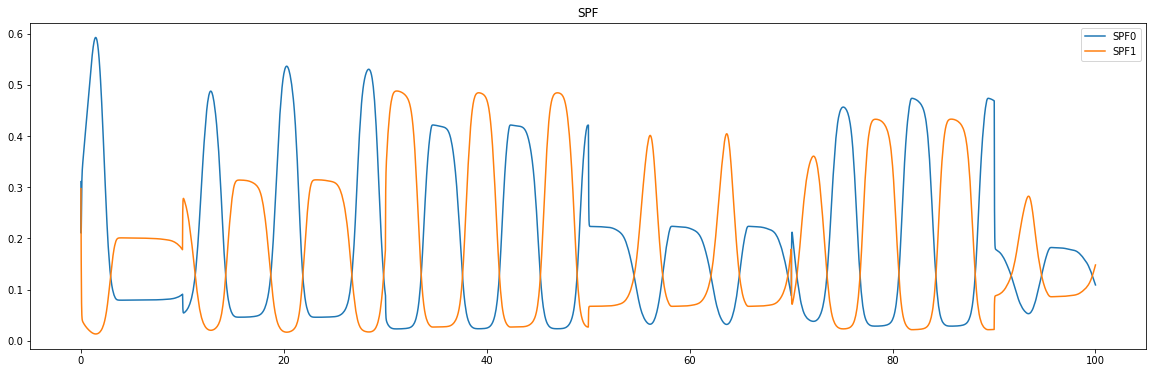

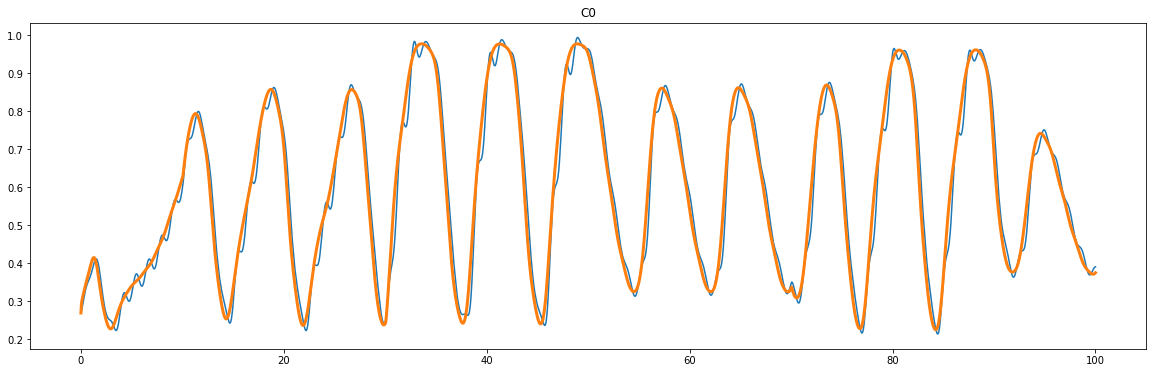

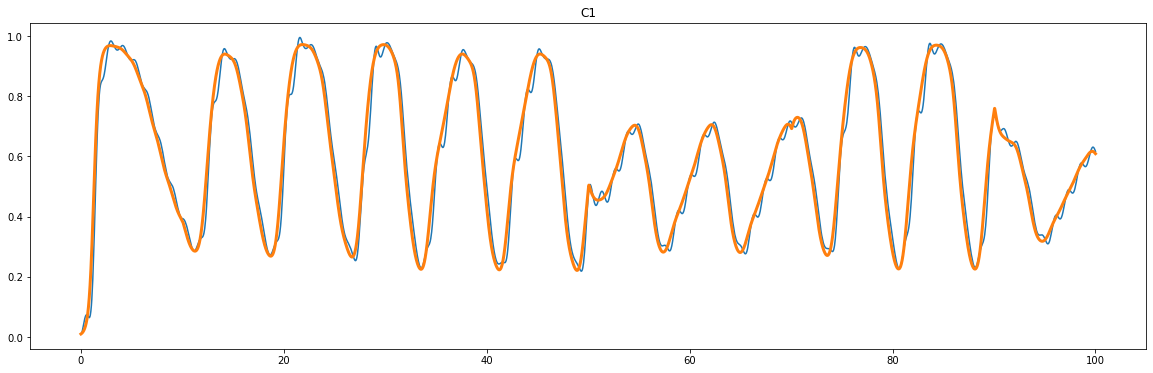

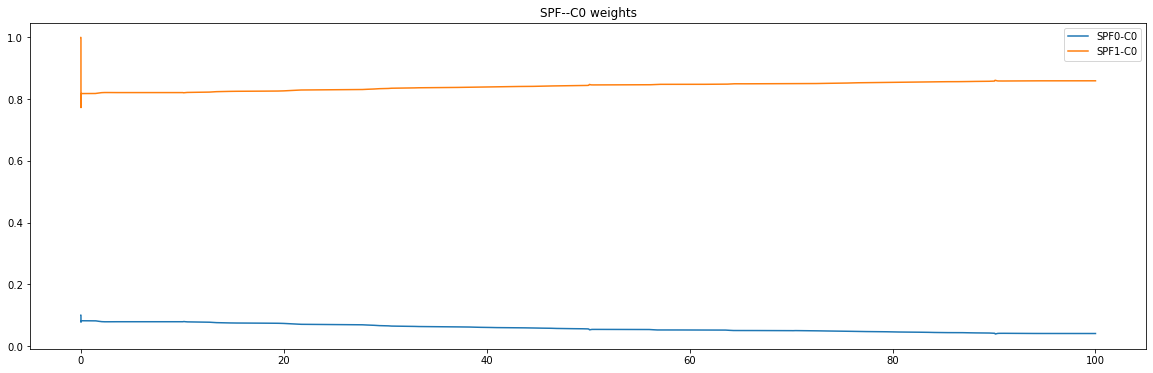

In [8]:
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')
print(SPF_data[:,-1])

# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
print(C1_data[-1])

# SPF--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[SPF_C0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['SPF0-C0', 'SPF1-C0'])
plt.title('SPF--C0 weights')

plt.show()

angle: 1.269665, vel: -0.907777


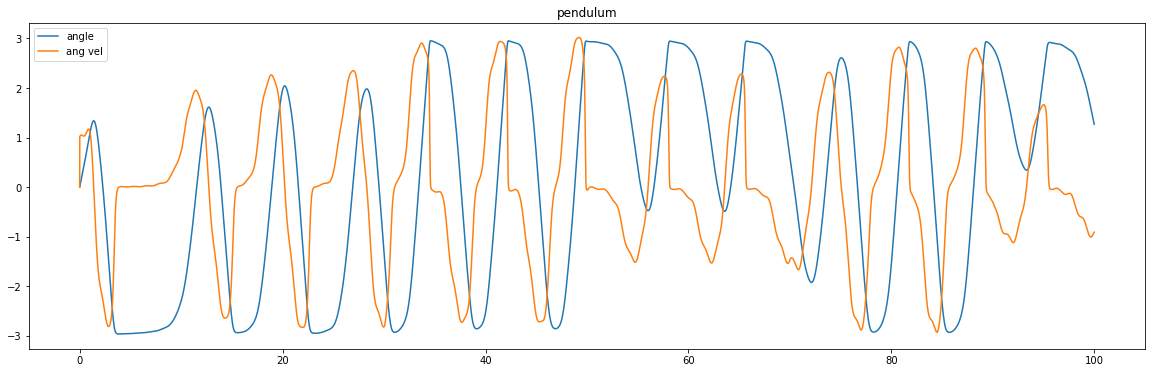

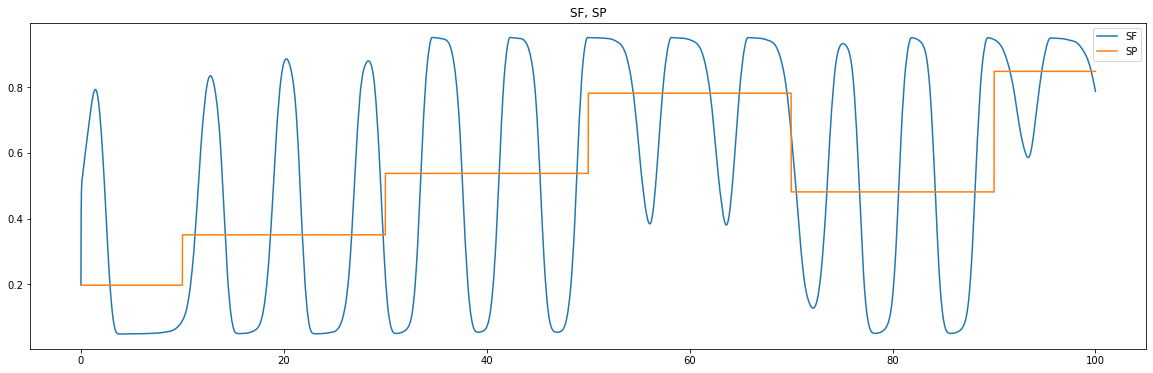

SF = [0.786889]
SP = [0.847297]


In [6]:
# P
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP')
plt.legend()
plt.title('SF, SP')
plt.show()
print('SF = [%f]' % (SF_data[0,-1]))
print('SP = [%f]' % (SP_data[0,-1]))

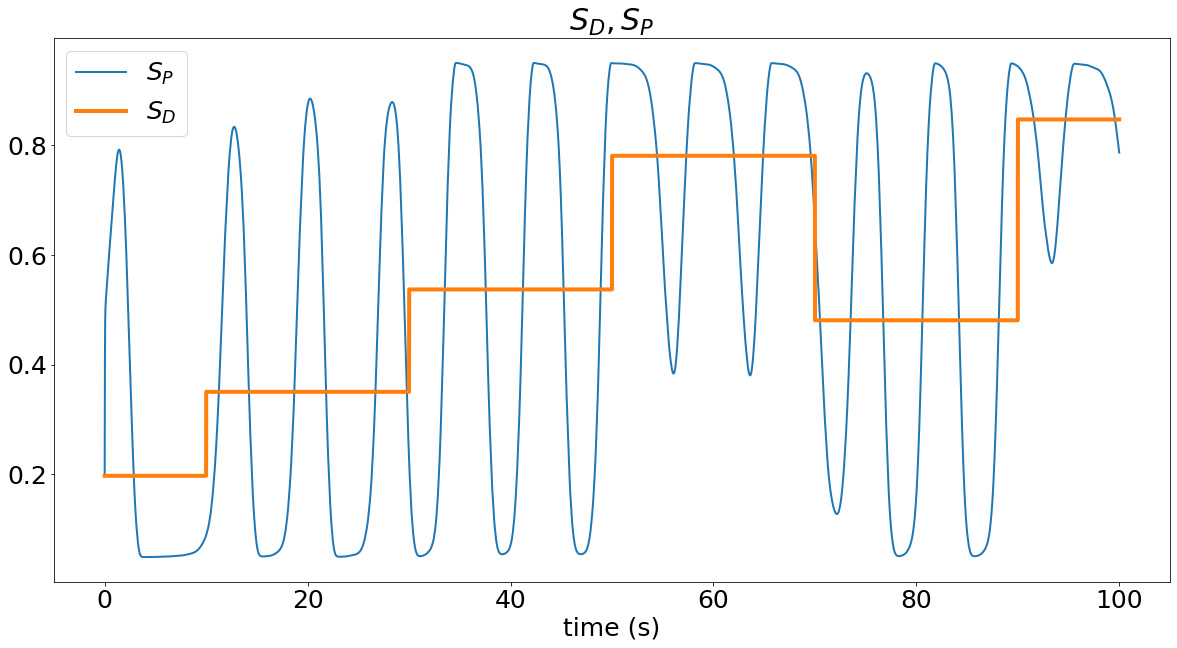

In [7]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

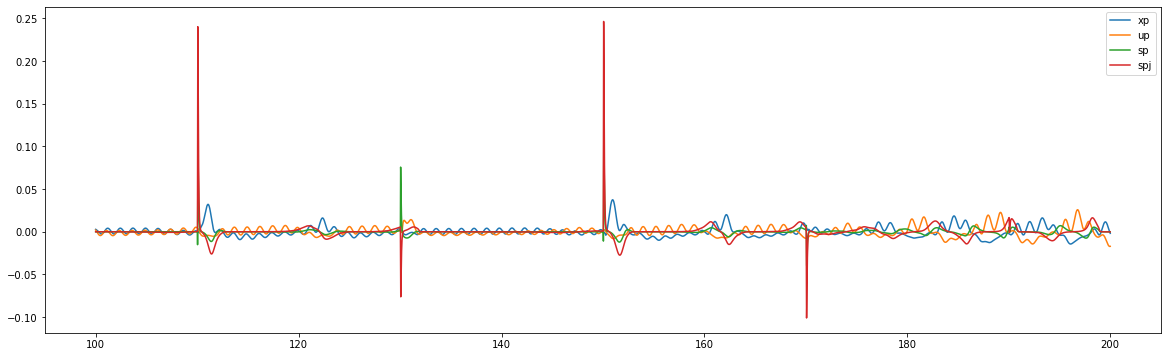

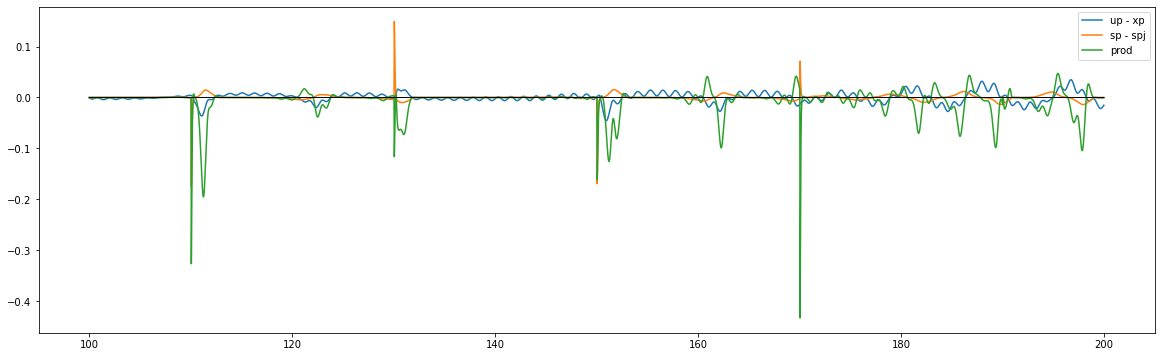

In [36]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [37]:
# checking some connections
print("Connections to control units")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))

Connections to control units
0) C (5) --> C, w=-2.000000, port=1, plant_out=None
1) SPF (2) --> C, w=0.054908, port=0, plant_out=None
2) SPF (3) --> C, w=0.845092, port=0, plant_out=None
Connections to plant
0) C (4, unit_types.am_oscillator2D) --> P, w=1.000000
1) C (5, unit_types.am_oscillator2D) --> P, w=-1.000000


---